In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(2)

## Making Timeseries

To simulate Fourier Series (FS), we need two parts: a latent simulator to simulate FS latent variables, and the FS simulator

SEM simulation will be used in the future, but for now, two simple simulators are availeble: uniform and normal independent variables. Below, we use "uniform"

In [36]:
from rad_sim.sem.basic import IndependentUniformLatents

iul = IndependentUniformLatents()

we want to simulate FS with 10 sine waves with sequence length 300. so we need 10 frequency (`w_0, ..., w_9`) + 10 phase shifts (`phi_0, ..., phi_9`). Sequence length will be used to give a threshold for frequency.

In [37]:
import numpy as np

seq_len = 300
num_sins = 10

frequency_range = [np.pi/seq_len, np.pi/20]
phaseshift_range = [-np.pi/4, np.pi/4]

var_list = [
    {'name': 'w_{}'.format(i), 'low': frequency_range[0], 'high': frequency_range[1]}
    for i in range(num_sins)
] + [
    {'name': 'phi_{}'.format(i), 'low': phaseshift_range[0], 'high': phaseshift_range[1]}
    for i in range(num_sins)
]

iul.set_nodes(var_list=var_list)

simulate for 800 samples

In [38]:
sample_size = 800

latents = iul.sample(sample_size=sample_size)

latents.head()

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,phi_0,phi_1,phi_2,phi_3,phi_4,phi_5,phi_6,phi_7,phi_8,phi_9
0,0.071611,0.140716,0.010623,0.146187,0.042803,0.063082,0.045529,0.088921,0.112639,0.131919,-0.212586,-0.009103,0.382877,0.115041,0.380731,-0.717880,-0.296876,0.580887,-0.703612,-0.412477
1,0.116077,0.037504,0.080270,0.069930,0.064305,0.106317,0.087510,0.109658,0.069698,0.108992,0.271354,0.065234,-0.268819,0.113126,-0.632636,0.126301,-0.615036,0.051110,-0.701778,-0.781720
2,0.010489,0.096289,0.106799,0.021472,0.064253,0.093539,0.029624,0.125593,0.061758,0.049662,0.083372,0.027534,-0.427389,-0.396181,-0.073797,-0.580834,-0.126059,-0.526649,0.011031,0.529205
3,0.054796,0.142156,0.134110,0.136753,0.024712,0.015472,0.052921,0.048750,0.029966,0.030010,-0.147003,-0.555760,0.636733,0.331019,-0.582252,-0.371354,0.666639,-0.513415,-0.655497,0.138699
4,0.031988,0.075876,0.037410,0.086605,0.059001,0.145453,0.069192,0.050886,0.013391,0.059433,-0.160286,-0.220940,-0.131485,-0.277477,0.167020,0.332116,0.159501,-0.741589,0.308878,0.556432


simulating FS series: frequencies `w_0` to `w_p`, in that order, are considered as dominant frequencies such that the most dominant frequency is `w_0`. we set the amplitude for the most dominant frequenct (`dominant_amplitude`), for the next ones, we set $a_i = \exp{(-di)}$ as the amplitude for `w_i` where `d` is an exponential decay. For example if `decay=0`, all the amplitudes are `1`. if `decay=1`, the amplitudes will be `[1, 0.36, ...]`.

We also consider an added gaussian noise. the `added_noise_sigma_ratio` defines the added noise scale as `scale = ratio * dominant amplitude`. Set to 0 to have no added noise

In [39]:
from rad_sim.simulators.temporal.deterministic import FourierSeries

# Fourier config
DECAY = 0.3
AMP = 1
SIGMA_RATIO = 0.1

# === SAMPLE FOURIER SERIES ===
fs = FourierSeries(
    sampled_latents=latents,
    dominant_amplitude=AMP,
    amplitude_exp_decay_rate=DECAY,
    frequency_prefix='w',
    phaseshift_prefix='phi',
    added_noise_sigma_ratio=SIGMA_RATIO
)
signals = fs.sample(seq_len=seq_len)

visualizing 2 signals as an example

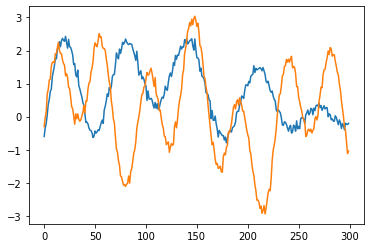

In [40]:
plt.plot(np.arange(seq_len), signals[2])
plt.plot(np.arange(seq_len), signals[3])
plt.show()

## Labeling Signals

### Labeling according to Latents

One way is to make the labels according to the latent variables. This can be done in two ways:

1. make $y = f(L)$ where L is the latent vector. Say $f(.)$ is a logistic model
2. sample for latents from two different distributions, while each distribution represents a class

#### Logistic model from latents

This can be done by the class `LatentLabelMaker`. In this case, a coefficient vector with the size of the latent vector is sampled uniformly, and the success probabilities to be used in a Bernoulli sampler will be calculated accordingly.

- `coef_min` and `coef_max` determine low and high of the coefficient values
- `normalize_latent` determines whether the sampled latent matrix will be normalized before the process
- `sigmoid_offset` adds an offset to the output of the linear model before being fed to sigmoid function. adding positive or negative values will increase or decrease the expected value of the label respectively

In the code below, we use the first 2 dominant frequencies to determine the labels

In [41]:
from rad_sim.sem.basic import LatentLabelMaker

lm = LatentLabelMaker(coef_min=1, coef_max=5, normalize_latent=True, sigmoid_offset=0)
y = lm.make_label(sampled_latents=latents[['w_0', 'w_1']].values)

y.mean()

0.5425

#### make FS from two latent distributions

The process is:
- select two latent distributions, e.g. normals with different means
- sample FS for the realizations of both distributions
- label the samples according to the distribution

In [42]:
from rad_sim.sem.basic import IndependentNormalLatents

mean_1 = 2*np.pi/30
mean_2 = 2*np.pi/80
sigma = 2*np.pi/100
phi = 0

var_list_1 = [
    {'name': 'w_{}'.format(i), 'mean': mean_1, 'sigma': sigma}
    for i in range(num_sins)
] + [
    {'name': 'phi_{}'.format(i), 'mean': phi, 'sigma': np.pi/10}
    for i in range(num_sins)
]

var_list_2 = [
    {'name': 'w_{}'.format(i), 'mean': mean_2, 'sigma': sigma}
    for i in range(num_sins)
] + [
    {'name': 'phi_{}'.format(i), 'mean': phi, 'sigma': np.pi/10}
    for i in range(num_sins)
]

inl_1 = IndependentNormalLatents()
inl_1.set_nodes(var_list=var_list_1)
l_1 = inl_1.sample(sample_size=int(sample_size/2))

inl_2 = IndependentNormalLatents()
inl_2.set_nodes(var_list=var_list_2)
l_2 = inl_2.sample(sample_size=int(sample_size/2))

fs_1 = FourierSeries(sampled_latents=l_1)
s_1 = fs_1.sample(seq_len=seq_len)

fs_2 = FourierSeries(sampled_latents=l_2)
s_2 = fs_2.sample(seq_len=seq_len)

y_1 = np.zeros(shape=(int(sample_size/2),))
y_2 = np.ones(shape=(int(sample_size/2),))

signals = np.concatenate([s_1, s_2])
y = np.concatenate([y_1, y_2])

### make labels according to the presence of a shapelet

Another way to make labels is to label the signals as class 1, if a shapelet exists in the signal, and 0 otherwise. A special case is if the shapelet exists at the end of the signal.

Let `D` be the sub-sequence of the same length at the end of all signals. We calculate the pairwise DTW distance among all Ds. We then can do clustering with `K=2` and take two centroids as the references, but there is an easier way: we take the sample number $i$ such that $i = \arg \min_i \mu_\text{DTW}$ where $\mu_\text{DTW}$ is the row-wise mean of the distance matrix. This way we find a sample which has the most "similar" sub-sequences. We take that as a reference shapelet for the class 0, and calculate a success probability proportional to the distance of other sub-sequences to this reference shapelet.

This can be done via `ShapeletDTWLabelMaker` class. The options are:
- `window_ratio` determines the window size of the shapelet relative to the total sequence length.
- `fast_approximation` Calculation of distance matrix becomes really slow as the number of samples grow. if this option is set to `True` then a subset of the samples are randomly selected for determining the reference shapelet. see the next option
- `sub_population`, if `fast_approx=True`, then this determines the number of samples which are considered in selecting the reference shapelet.

In [46]:
# LATENTS
sample_size = 500
latents = iul.sample(sample_size=sample_size)

# FS
fs = FourierSeries(
    sampled_latents=latents,
    amplitude_exp_decay_rate=0.05,
    added_noise_sigma_ratio=0.1
)
signals = fs.sample(seq_len=seq_len)

# LABELS

lm = ShapeletDTWLabelMaker(window_ratio=0.2, fast_approximation=False, parallel=True)
y = lm.make_label(signals)

To sanity-check the result, we take a look at the reference shapelet, the closest and the furthest signal to it (excluding the reference signal itself)

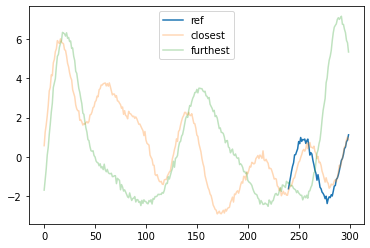

In [47]:
ref = lm.ref_shapelet
# we take the second index in argsort, as the first index is the reference signal itself
closest_idx = lm.success_probs.argsort()[1]
furthest_idx = lm.success_probs.argmax()

win_len = len(ref)
plt.plot(np.arange(seq_len - win_len, seq_len), ref, label='ref')
plt.plot(np.arange(seq_len), signals[closest_idx], label='closest', alpha=0.3)
plt.plot(np.arange(seq_len), signals[furthest_idx], label='furthest', alpha=0.3)
plt.legend()
plt.show()